# Anomaly Detection on Time Series Data
In this lab we'll generate [ synthetic ] time-series data and train a DL model [ autoencoder ] to encode [ summarize/embed ] and reconstruct sliding windows from this dataset. In this context, the amount of reconstruction error (the difference between an input and the trained network's output) is used as an indicator of potential anomalies. To test this we'll mix in artificial anomalies into normal data and analyze the model's reconstruction error.

# Pre-requisites:
Prerequisites: Matplotlib, Numpy, Pandas, Tensorflow [ 2.0.0-beta-1 ] + Keras, and mpld3 

In [1]:
import tensorflow
if tensorflow.__version__ != '2.0.0-beta1':
    !pip install tensorflow==2.0.0-beta1

# Import libraries

In [2]:
import sys; sys.path.append('../utils')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tight_plot import tight_plot
from customcolors import *
import nnViz

In [4]:
%matplotlib notebook

# Generate Synthetic Data

In [5]:
numSyntheticSamples = 100000
syntheticDataRange = np.linspace( 0, np.pi*numSyntheticSamples/10.0, numSyntheticSamples)
syntheticData = np.sin( syntheticDataRange ) \
                    * np.random.randint( 1, 10, size = numSyntheticSamples ) * 1/2. \
                    + np.random.randint( -1, 1, size = numSyntheticSamples ) * 1/2.

In [6]:
if syntheticData.ndim < 2:
    syntheticData = np.expand_dims(syntheticData, axis=1)

<IPython.core.display.Javascript object>


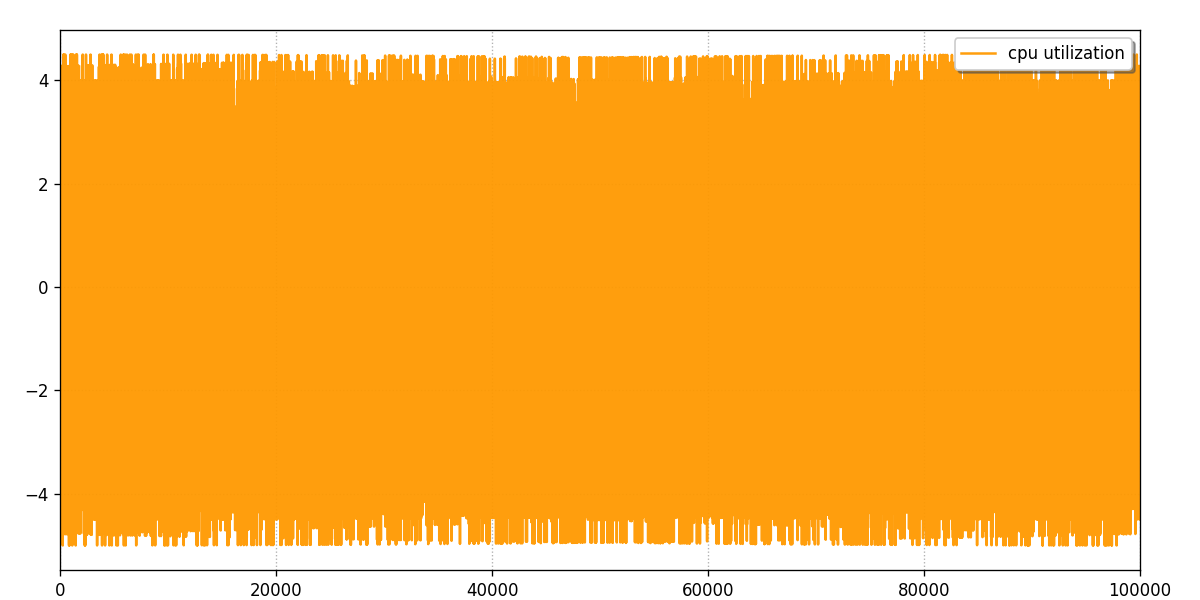

In [7]:
tight_plot(syntheticData, rawDataColor,'cpu utilization')

# Define Model Hyper-parameters

In [8]:
# Define hyperparameters

# of samples per sensor for the micro model [sliding window of ~2.5 hrs]
hParams = {}

hParams['windowSamples'] = 30
hParams['bottleNeckUnits'] = 5
hParams['nSensors'] = 1
hParams['overlapPercentage'] = .99
hParams['advanceSamples'] = ( hParams['windowSamples'] - int( np.floor( hParams['windowSamples'] * hParams['overlapPercentage'] ) ))

# Split into train and test set (.25 test data)

In [9]:
def train_test_split (x, testDataRatio = .25, trainDataAtStart = True):
    assert x.ndim > 1
    if trainDataAtStart:
        splitIndex = int( ( 1.0 - testDataRatio) * x.shape[0] )    
        
        xTrain = x[ 0:splitIndex, :]
        xTest = x[ splitIndex:, :]
    else:
        splitIndex = int( testDataRatio * x.shape[0] )
        xTest = x[ 0:splitIndex, :]
        xTrain = x[ splitIndex:, :]
        
    return xTrain, xTest

In [10]:
trainSplit, testSplit = train_test_split( syntheticData )

# Normalize data ( 0 mean, unit standard deviation )

In [11]:
# find normalization statistics
trainMeans = np.mean(trainSplit, axis=0)
trainSTDevs = np.std(trainSplit, axis=0)
print(trainMeans); print(trainSTDevs)

# normalize [ in place / overwrite ]
normalizedTrainData = (trainSplit - trainMeans) / (trainSTDevs + .0001)
normalizedTestData = (testSplit - trainMeans) / (trainSTDevs + .0001)

[-0.25119951]
[2.00369107]


# Generate Overlapping Windows

In [12]:
def reshape_into_shuffled_data_windows ( x, windowSize, advanceSamples ):
    nWindows = int( np.floor( (x.shape[0] - windowSize)/(advanceSamples*1.0) ) )
    # shuffle indexes
    shuffledWindowInds = np.arange(nWindows)
    np.random.shuffle(shuffledWindowInds)    
        
    nSensors = x.shape[1]
    outputMatrix = np.zeros((nWindows, windowSize * nSensors))
    
    # update data matrix on a row by row basis (choosing shuffled windows per row)
    for iWindow in range(nWindows):
        startIndex = shuffledWindowInds[iWindow] * advanceSamples
        endIndex = startIndex + windowSize
        
        # flatten/interleave sensor values
        for iSensor in range(nSensors):
            outputMatrix[iWindow, iSensor::nSensors] = x[startIndex:endIndex, iSensor]
    
    return outputMatrix, shuffledWindowInds


<IPython.core.display.Javascript object>


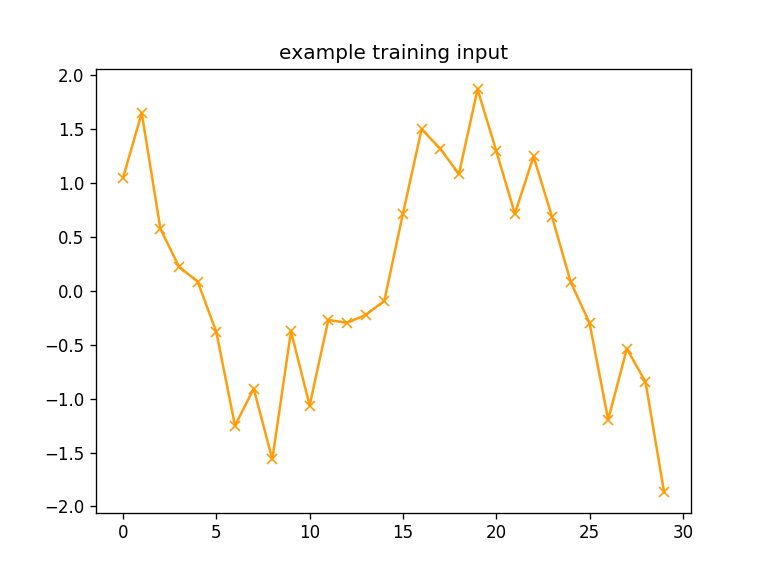

Text(0.5, 1.0, 'example training input')

In [13]:
trainMatrix, trainShuffledWindowInds = reshape_into_shuffled_data_windows(normalizedTrainData, hParams['windowSamples'], hParams['advanceSamples'])
testMatrix, testShuffledWindowInds = reshape_into_shuffled_data_windows(normalizedTestData, hParams['windowSamples'], hParams['advanceSamples'])

plt.figure()
plt.plot(trainMatrix[1,:], 'x-', color = rawDataColor)
plt.title('example training input')

# ML/DL Imports

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import metrics

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Model Architecture

In [15]:
hParams['inputOutputDimensionality'] = int( hParams['windowSamples'] * hParams['nSensors'] ) 
assert hParams['inputOutputDimensionality'] == trainMatrix.shape[1]

In [16]:
# Define model
model = Sequential()


model.add( Dense( 20, input_dim = hParams['inputOutputDimensionality'], activation = 'linear'))

model.add( Dense( 10, activation = 'sigmoid'))

model.add( Dense( hParams['bottleNeckUnits'], activation = 'sigmoid'))

model.add( Dense( 10, activation = 'sigmoid'))

model.add( Dense( 20, activation = 'sigmoid'))

model.add( Dense( hParams['inputOutputDimensionality'], activation = 'linear',))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
Total params: 1,795
Trainable params: 1,795
Non-trainable params: 0
______________________________________________________

<IPython.core.display.Javascript object>


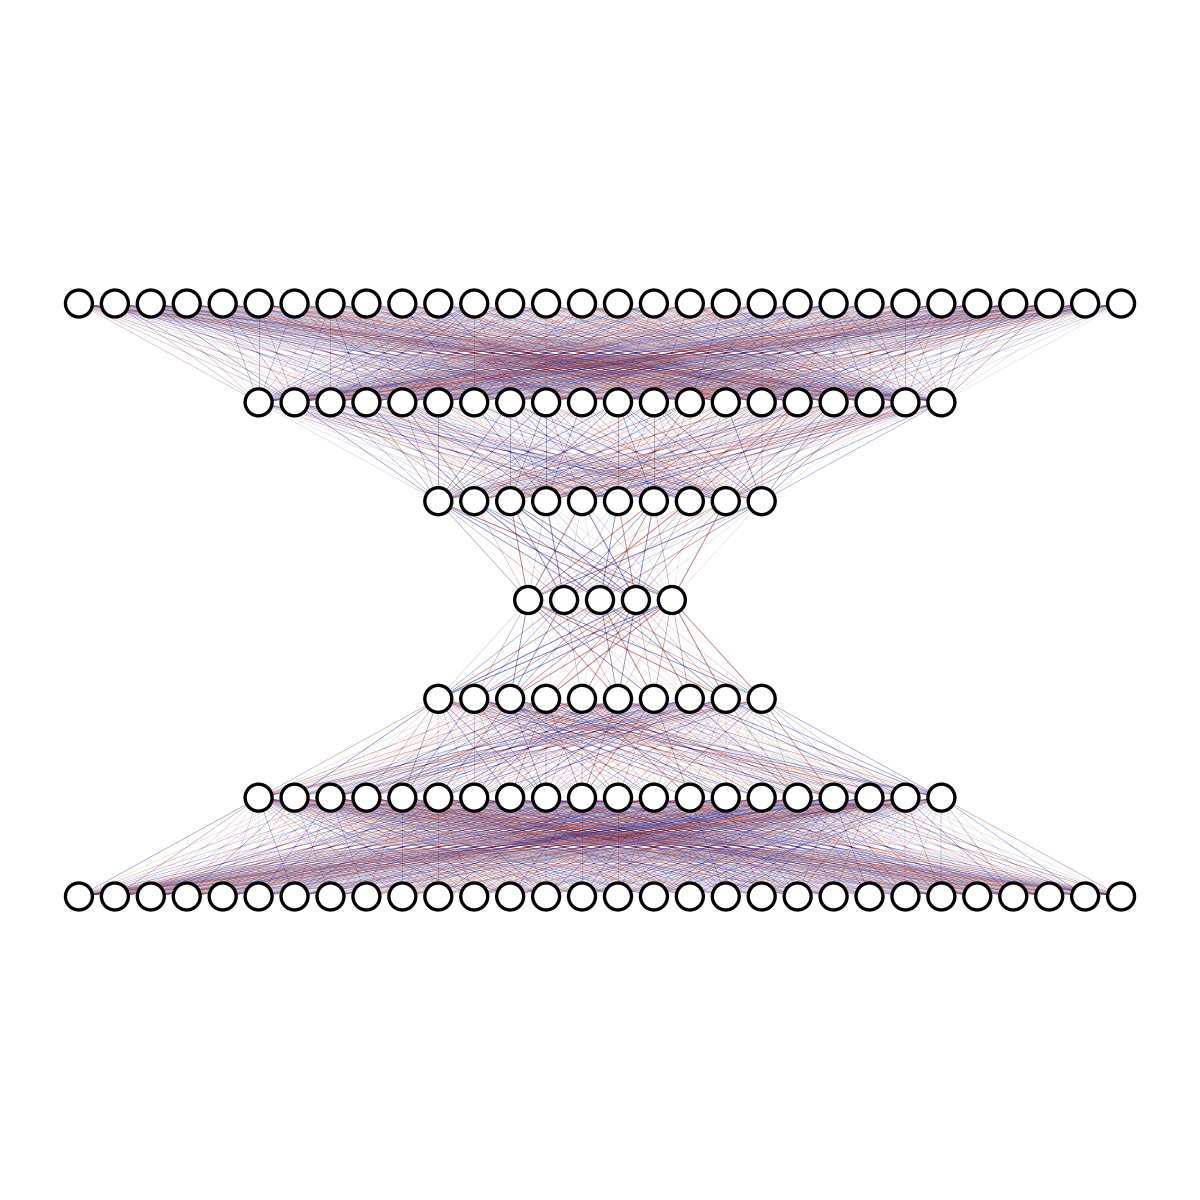

In [17]:
plt.figure(figsize=(10,10))
plt.subplots_adjust( left = 0.01, right = 0.99, top = 0.99, bottom = 0.01, wspace = 0.01 )
nnViz.visualize_model(model)

In [18]:
model.compile(optimizer = 'adam', loss = 'mse')

# Train Model

In [20]:
early_stopping = EarlyStopping( monitor = 'val_loss', patience = 10)
checkpointer = ModelCheckpoint( filepath = 'best_model_weights.hdf5', verbose=1, save_best_only = True)

# keras version 2+
history = model.fit( trainMatrix, trainMatrix,
               batch_size = 256, epochs = 200,
               shuffle = True,
               callbacks = [early_stopping, checkpointer],
               validation_data = (testMatrix, testMatrix) )

Train on 74970 samples, validate on 24970 samples
Epoch 1/200
67840/74970 [==========================>...] - ETA: 0s - loss: 0.2012
Epoch 00001: val_loss improved from inf to 0.20116, saving model to best_model_weights.hdf5
74970/74970 [==============================] - 1s 8us/sample - loss: 0.2012 - val_loss: 0.2012
Epoch 2/200
68352/74970 [==========================>...] - ETA: 0s - loss: 0.2013
Epoch 00002: val_loss did not improve from 0.20116
74970/74970 [==============================] - 1s 7us/sample - loss: 0.2012 - val_loss: 0.2012
Epoch 3/200
68096/74970 [==========================>...] - ETA: 0s - loss: 0.2013
Epoch 00003: val_loss did not improve from 0.20116
74970/74970 [==============================] - 1s 7us/sample - loss: 0.2012 - val_loss: 0.2012
Epoch 4/200
68608/74970 [==========================>...] - ETA: 0s - loss: 0.2012
Epoch 00004: val_loss did not improve from 0.20116
74970/74970 [==============================] - 1s 7us/sample - loss: 0.2012 - val_loss: 0.20

<IPython.core.display.Javascript object>


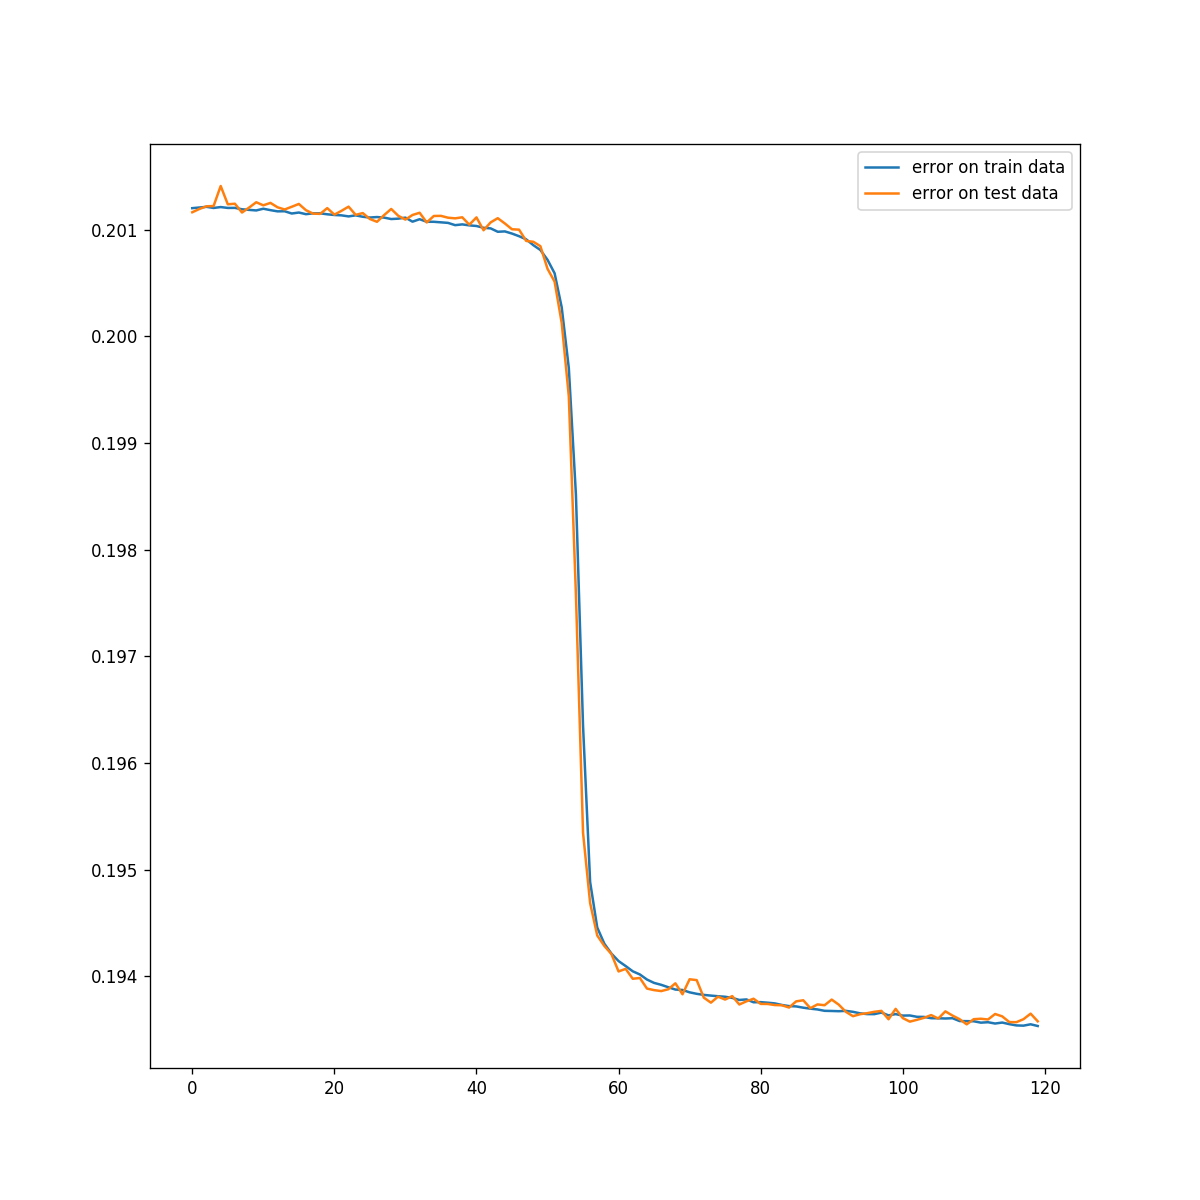

In [21]:
plt.figure( figsize = (10,10) )
plt.plot( history.history['loss'] )
plt.plot( history.history['val_loss'] )
plt.legend(['error on train data', 'error on test data'])

# Load Best Weights [ on validation data ]

In [22]:
model.load_weights('best_model_weights.hdf5')
model.compile(optimizer = 'adam', loss = 'mse') # need to recompile model to be able to run prediction

# Create Anomalies, and Mix/Insert into Training Data

<IPython.core.display.Javascript object>


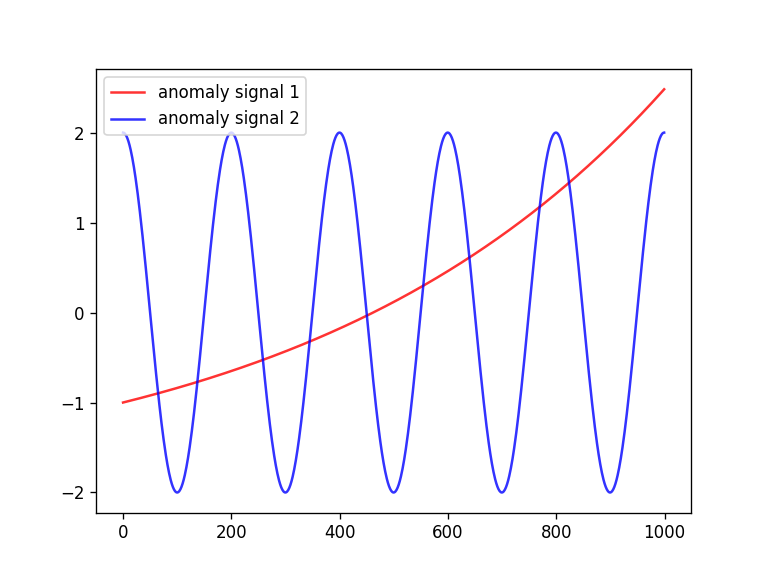

In [23]:
anomalySignal1 = np.exp(np.linspace(0, 1.5, 1000)) - 2
anomalySignal2 = np.cos(np.linspace(0,2*np.pi * 5, 1000)) * 2

anomalySignal1 = np.expand_dims(anomalySignal1, axis=1)
anomalySignal2 = np.expand_dims(anomalySignal2, axis=1)

plt.figure()

plt.plot(anomalySignal1, color = anomalyColor1)
plt.plot(anomalySignal2, color = anomalyColor2)

plt.legend(['anomaly signal 1', 'anomaly signal 2'])

In [25]:
startIndex = 0
endIndex = 3000
anomalyLen1 = len(anomalySignal1)
anomalyLen2 = len(anomalySignal1)

In [26]:
targetData = normalizedTestData[startIndex:endIndex]

anomalyStartIndex_1 = 500
anomalyEndIndex_1 = anomalyStartIndex_1 + anomalyLen1

targetData[anomalyStartIndex_1:anomalyEndIndex_1] = anomalySignal1

anomalyStartIndex_2 = 2000
anomalyEndIndex_2 = anomalyStartIndex_2 + anomalyLen2

targetData[anomalyStartIndex_2:anomalyEndIndex_2] = anomalySignal2


anomalousInds_1 = np.arange(int(anomalyStartIndex_1/hParams['windowSamples']), int(anomalyEndIndex_1/hParams['windowSamples']), dtype=int)
anomalousInds_2 = np.arange(int(anomalyStartIndex_2/hParams['windowSamples']), int(anomalyEndIndex_2/hParams['windowSamples']), dtype=int)

# Plot Target/Raw vs Predicted Data

In [27]:
from sliding_window_inference import windowed_predict, windowed_predict_bottleneck_activation
predictedData = windowed_predict ( model, targetData, hParams['inputOutputDimensionality'])
error = np.sqrt((targetData - predictedData)**2)

Using TensorFlow backend.


number of windows: 100


<IPython.core.display.Javascript object>


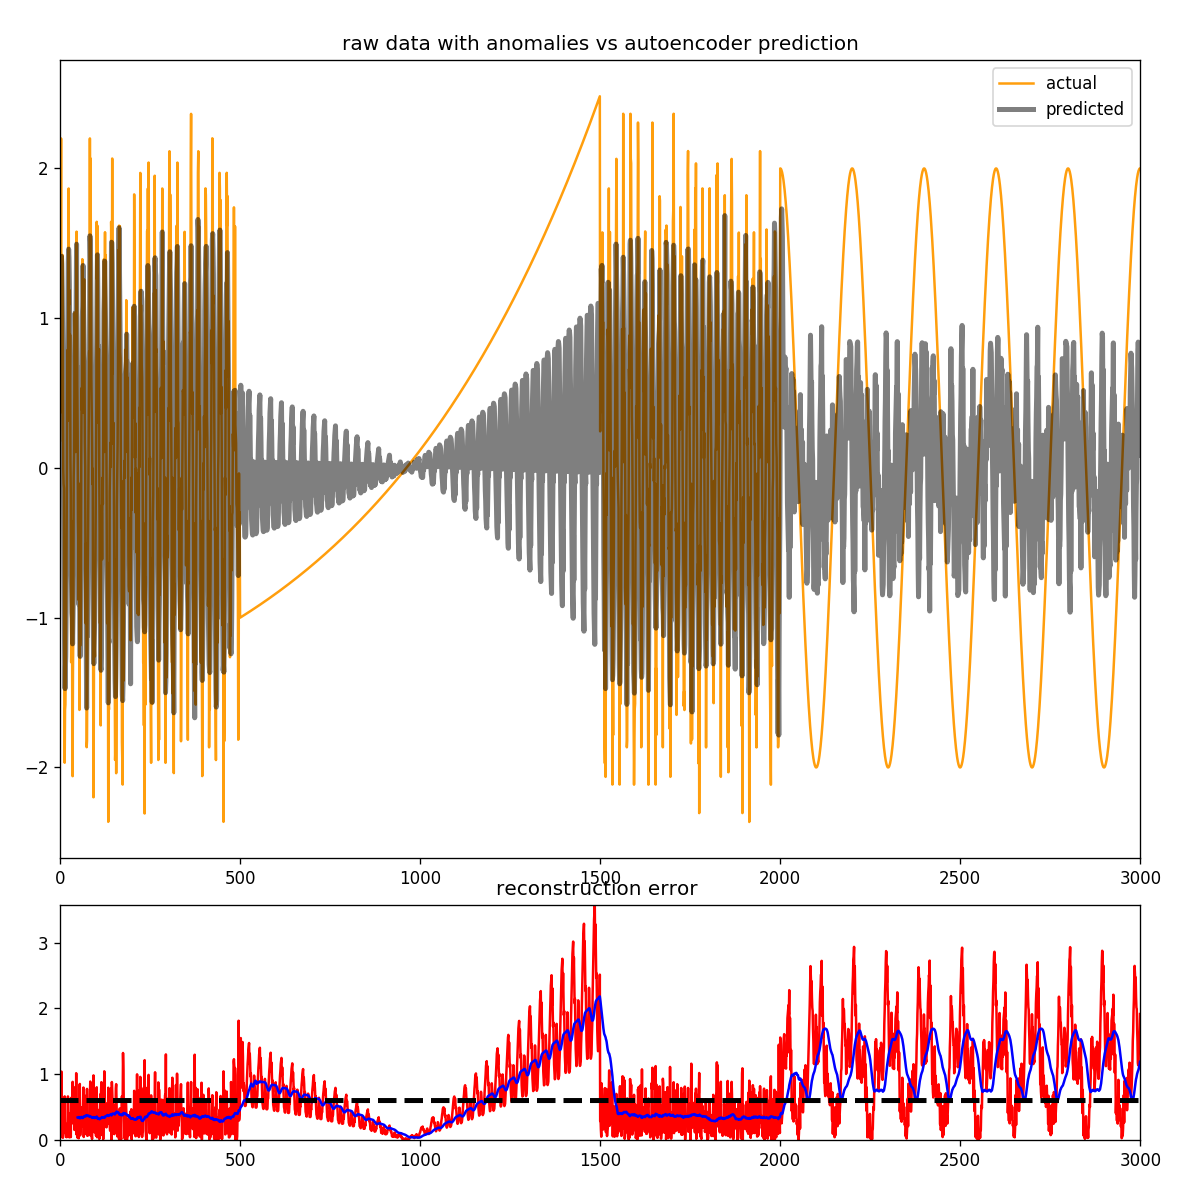

Text(0.5, 1.0, 'reconstruction error ')

In [28]:
plt.figure( figsize = (10,10) )

ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax1)
plt.subplots_adjust( left = 0.05, right = 0.95, top = 0.95, bottom = 0.05, wspace = 0.01 )

ax1.plot(targetData, color = rawDataColor)
ax1.plot(predictedData, color = contrastColor2, linewidth=3)
ax1.set_title('raw data with anomalies vs autoencoder prediction')
ax1.legend(['actual', 'predicted'])


ax2.autoscale(enable=True, axis='both', tight=True)
ax2.plot(error, 'r')

rollingMean = pd.Series(error.squeeze()).rolling(window=50).mean()

ax2.plot(rollingMean, 'b')

threshLine = np.ones((len(rollingMean),1)) * .6
ax2.plot(threshLine, 'k--', linewidth = 3)
ax2.set_title('reconstruction error ')

## Remove Last Two Layers [ focus on bottleneck activations ]

<IPython.core.display.Javascript object>


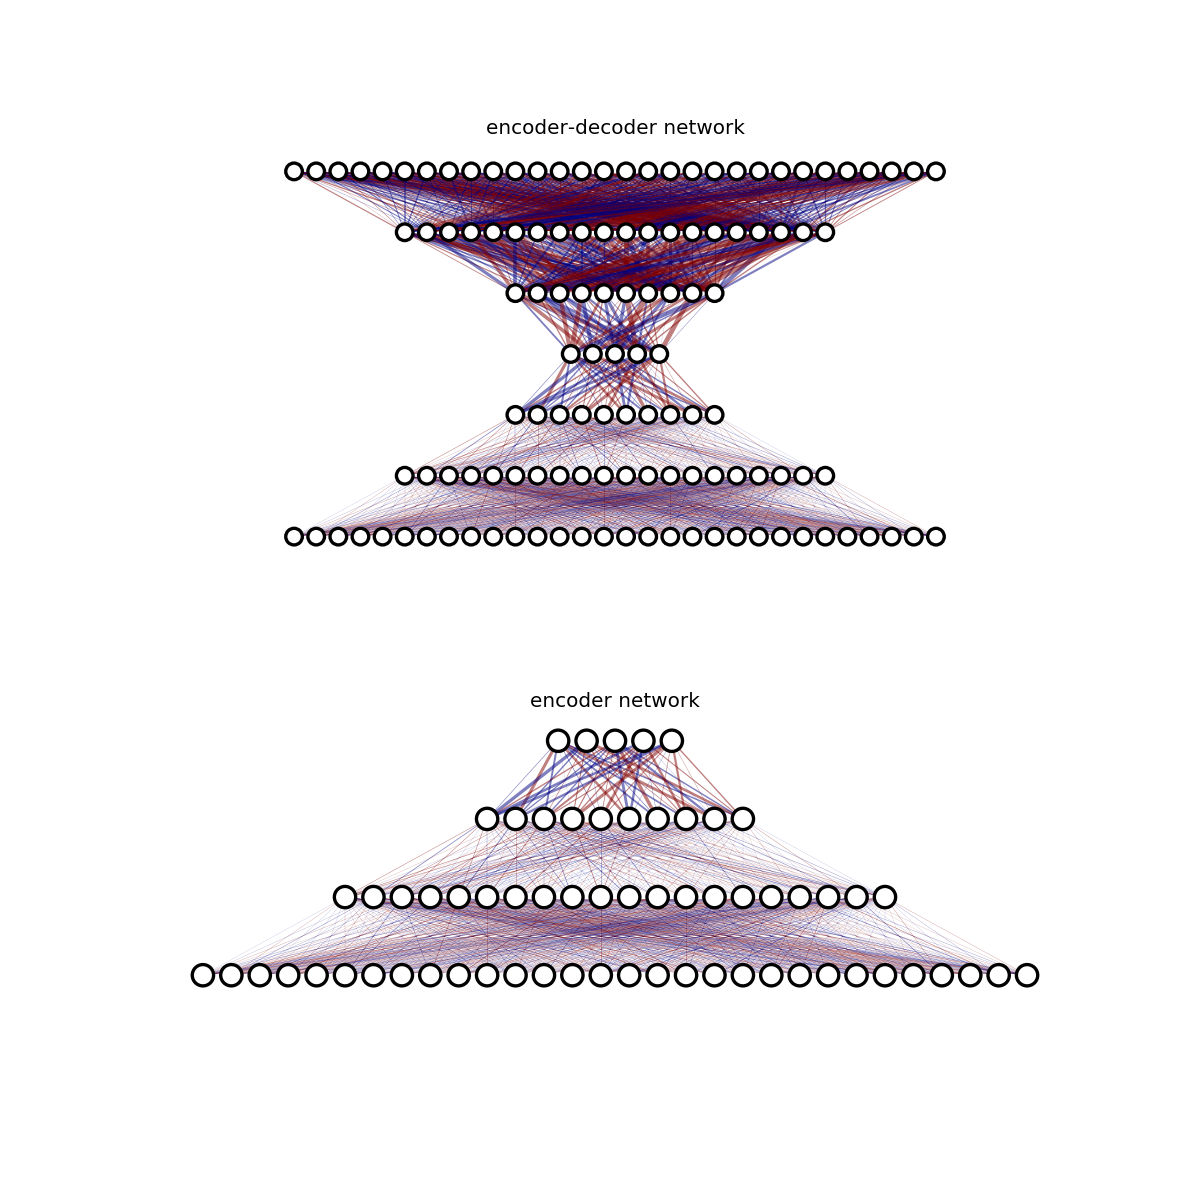

Text(0.5, 1.0, 'encoder network')

In [29]:
plt.figure( figsize = (10, 10) )

plt.subplot(2,1,1)
nnViz.visualize_model(model)
plt.title('encoder-decoder network')

plt.subplot(2,1,2)
model.pop(); model.pop(); model.pop()
nnViz.visualize_model(model)
plt.title('encoder network')


In [30]:
model.compile(optimizer = 'adam', loss = 'mse')

In [31]:
bottleNeckSize = hParams['bottleNeckUnits'] #model.layers[-1].get_config()['units']
bottleneckActivations = windowed_predict_bottleneck_activation (model, targetData, hParams['inputOutputDimensionality'], bottleNeckSize)

number of windows: 100


# PCA

In [32]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pca = PCA(n_components = 3)
PCA_bottleneckActivations = pca.fit_transform(bottleneckActivations)

# Interactive Interpretation

In [33]:
installMPLD3 = True
if installMPLD3:
    !conda install -c conda-forge mpld3 --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/tensorflow_p36

  added / updated specs: 
    - mpld3


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    mpld3-0.3                  |             py_1          99 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be INSTALLED:

    mpld3:           0.3-py_1          conda-forge

The following packages will be UPDATED:

    ca-certificates: 2019.5.15-0                   --> 2019.6.16-hecc5488_0 conda-forge
 

In [34]:
import mpld3
from mpld3 import plugins, utils
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


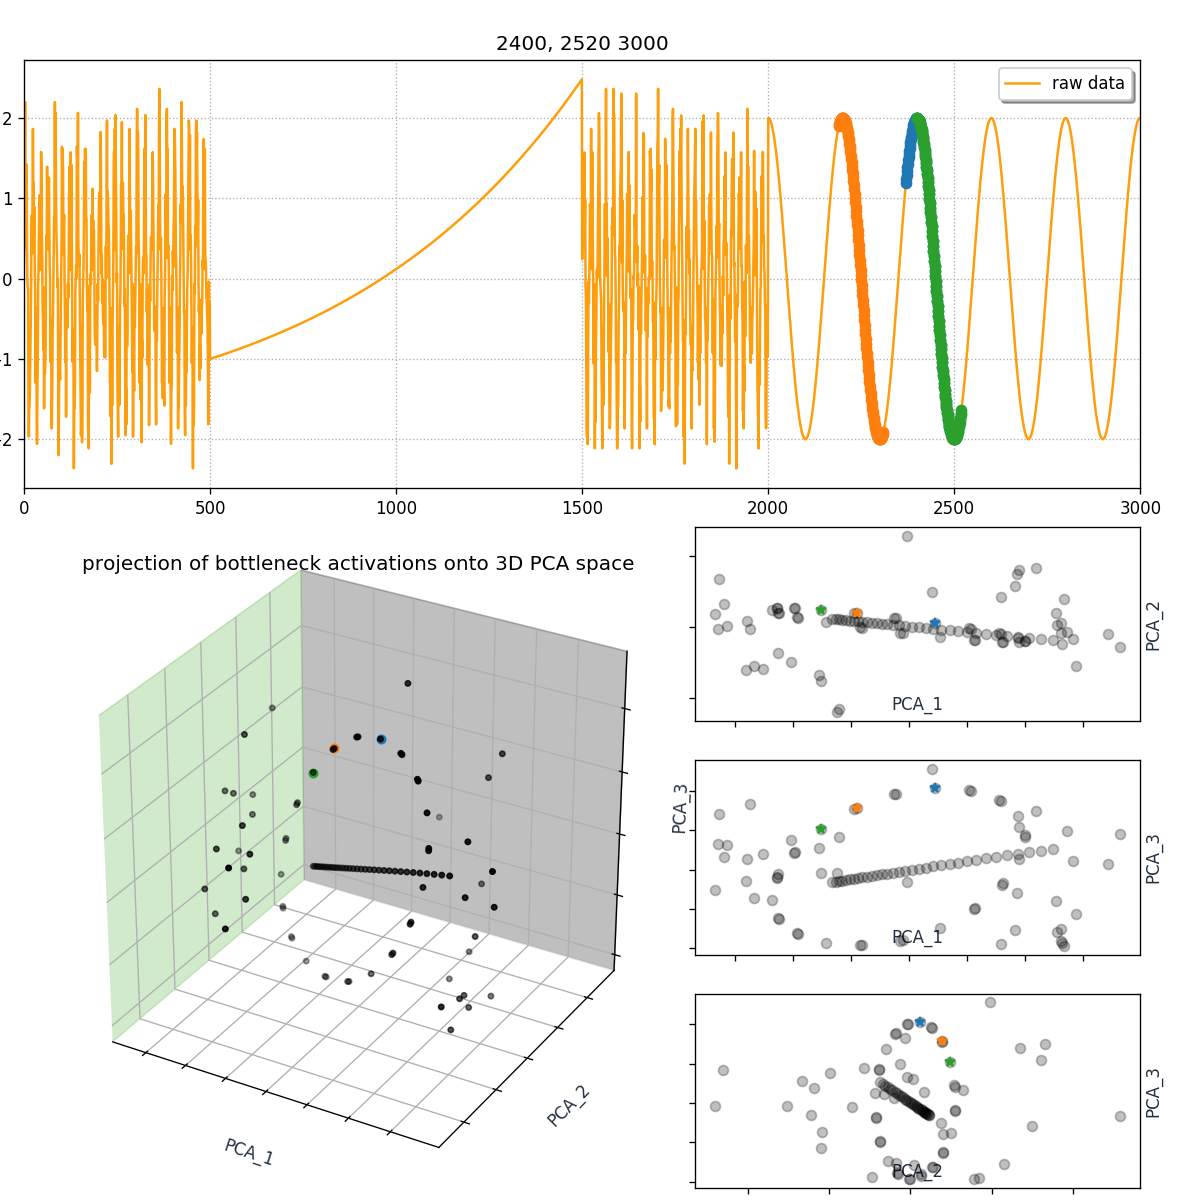

In [35]:
fig = plt.figure(figsize=(10,10))

plt.subplots_adjust( left = 0.02, right = 0.95, top = 0.95, bottom = 0.01, wspace = 0.01 )

ax1 = plt.subplot2grid((5, 5), (0, 0), rowspan=2, colspan=5)
ax1.plot( range(len(targetData)), targetData, color = rawDataColor )
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.legend(['raw data'], loc='upper right', shadow=True)
ax1.grid(linestyle='dotted')

ax2 = plt.subplot2grid((5, 5), (2, 0), rowspan=3, colspan=3, projection='3d')
ax2.scatter(PCA_bottleneckActivations[:, 0], PCA_bottleneckActivations[:,1], PCA_bottleneckActivations[:,2], color=nikeBlack, s=10)
ax2.set_xticklabels([]); ax2.set_yticklabels([]); ax2.set_zticklabels([]);
ax2.set_title('projection of bottleneck activations onto 3D PCA space')
ax2.set_xlabel('PCA_1', color=amazonSquidInk)
ax2.set_ylabel('PCA_2', color=amazonSquidInk)
ax2.set_zlabel('PCA_3', color=amazonSquidInk)

ax2.w_xaxis.set_pane_color(rawDataColor2); ax2.w_yaxis.set_pane_color(contrastColor3); ax2.w_zaxis.set_pane_color((1, 1, 1, .4))

ax3 = plt.subplot2grid((5, 5), (2, 3), rowspan=1, colspan=2)
ax3.plot ( PCA_bottleneckActivations[:,0], PCA_bottleneckActivations[:,1], 'o', color=contrastColor3, picker = 5 )
ax3.set_xticklabels([]); ax3.set_yticklabels([])
ax3.set_xlabel('PCA_1', color=amazonSquidInk); ax3.xaxis.set_label_coords(0.5, 0.13)
ax3.set_ylabel('PCA_2', color=amazonSquidInk); ax3.yaxis.set_label_coords(1.05, 0.5)

ax4 = plt.subplot2grid((5, 5), (3, 3), rowspan=1, colspan=2)
ax4.plot ( PCA_bottleneckActivations[:,0], PCA_bottleneckActivations[:,2], 'o', color=contrastColor3, picker = 5 )
ax4.set_xticklabels([]); ax4.set_yticklabels([])
ax4.set_xlabel('PCA_1', color=amazonSquidInk); ax4.xaxis.set_label_coords(0.5, 0.13)
ax4.set_ylabel('PCA_3', color=amazonSquidInk); ax4.yaxis.set_label_coords(1.05, 0.5)

ax5 = plt.subplot2grid((5, 5), (4, 3), rowspan=1, colspan=2)
ax5.plot ( PCA_bottleneckActivations[:,1], PCA_bottleneckActivations[:,2], 'o', color=contrastColor3, picker = 5 )
ax5.set_xticklabels([]); ax5.set_yticklabels([])
ax5.set_xlabel('PCA_2', color=amazonSquidInk); ax5.xaxis.set_label_coords(0.5, 0.13)
ax5.set_ylabel('PCA_3', color=amazonSquidInk); ax5.yaxis.set_label_coords(1.05, 0.5)


In [36]:
def updatePlots ( ind ):
    if len(ind) > 0:
        targetInd = ind[0]
        lowerBound = max( 0, int((targetInd-2) * hParams['inputOutputDimensionality']) )
        upperBound = min( len(targetData), int((targetInd + 2) * hParams['inputOutputDimensionality']) )
        
        strOut = str(lowerBound) + ', ' + str(upperBound) + ' ' + str(len(targetData))
        ax1.set_title(strOut)        
        
        ax1.plot( list(range( lowerBound, upperBound)), targetData[ lowerBound:upperBound ], 'o' )
        ax2.scatter(PCA_bottleneckActivations[targetInd, 0], PCA_bottleneckActivations[targetInd,1], PCA_bottleneckActivations[targetInd,2], s=25)
        
        ax3.plot ( PCA_bottleneckActivations[targetInd,0], PCA_bottleneckActivations[targetInd,1], '*', picker = 5 )
        ax4.plot ( PCA_bottleneckActivations[targetInd,0], PCA_bottleneckActivations[targetInd,2], '*', picker = 5 )
        ax5.plot ( PCA_bottleneckActivations[targetInd,1], PCA_bottleneckActivations[targetInd,2], '*', picker = 5 )
        


In [37]:
def on_pick(event):
    if event.mouseevent.inaxes != ax2:
        eventArtist = event.artist
        xdata, ydata = eventArtist.get_data()
        ind = event.ind        
        updatePlots(ind)
        
cid = fig.canvas.mpl_connect('pick_event', on_pick)

# End Result

<IPython.core.display.Javascript object>


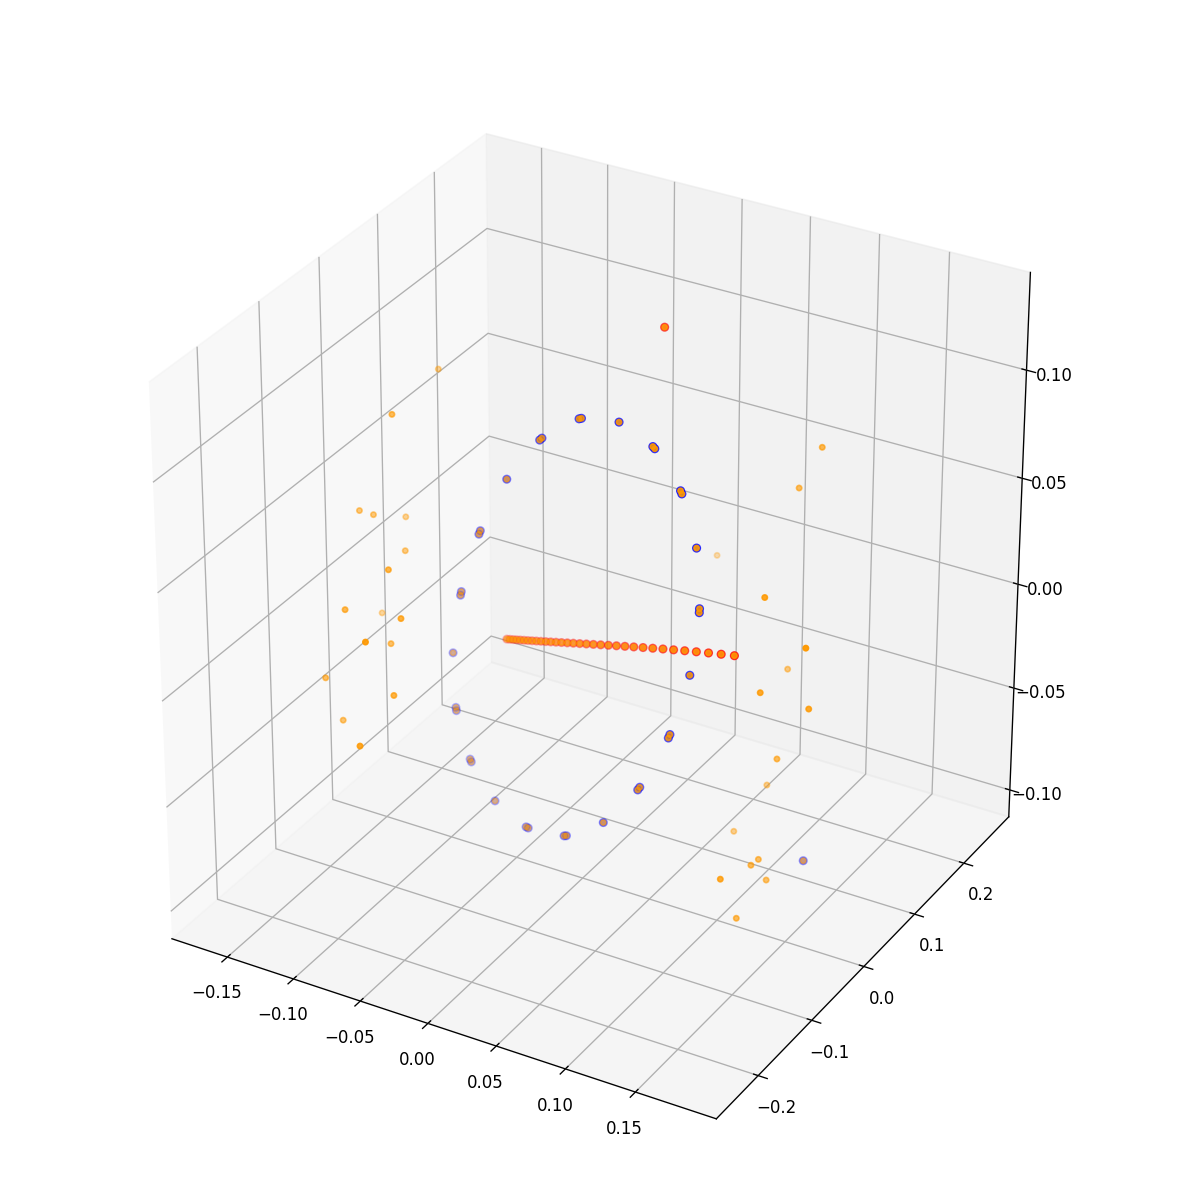

In [38]:
fig = plt.figure( figsize = (10, 10) ) 
ax = fig.add_subplot(111, projection='3d')
plt.subplots_adjust( left = 0.02, right = 0.95, top = 0.95, bottom = 0.01, wspace = 0.01 )


ax.scatter(PCA_bottleneckActivations[:, 0], PCA_bottleneckActivations[:,1], PCA_bottleneckActivations[:,2], color=rawDataColor, s=10)
ax.scatter(PCA_bottleneckActivations[anomalousInds_1, 0], PCA_bottleneckActivations[anomalousInds_1, 1], PCA_bottleneckActivations[anomalousInds_1, 2], color=anomalyColor1, s = 20)
ax.scatter(PCA_bottleneckActivations[anomalousInds_2, 0], PCA_bottleneckActivations[anomalousInds_2, 1], PCA_bottleneckActivations[anomalousInds_2, 2], color=anomalyColor2, s = 20)

# Appendix - Alternative Dimensionality Reduction Methods

# tSNE 3D

In [39]:
from sklearn.manifold import TSNE

embeddedBottleneckActivations = TSNE(n_components = 3, perplexity = 6, learning_rate = 10, method='exact', verbose = 1).fit_transform(bottleneckActivations)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.019500
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.046060
[t-SNE] KL divergence after 1000 iterations: 0.149122


<IPython.core.display.Javascript object>


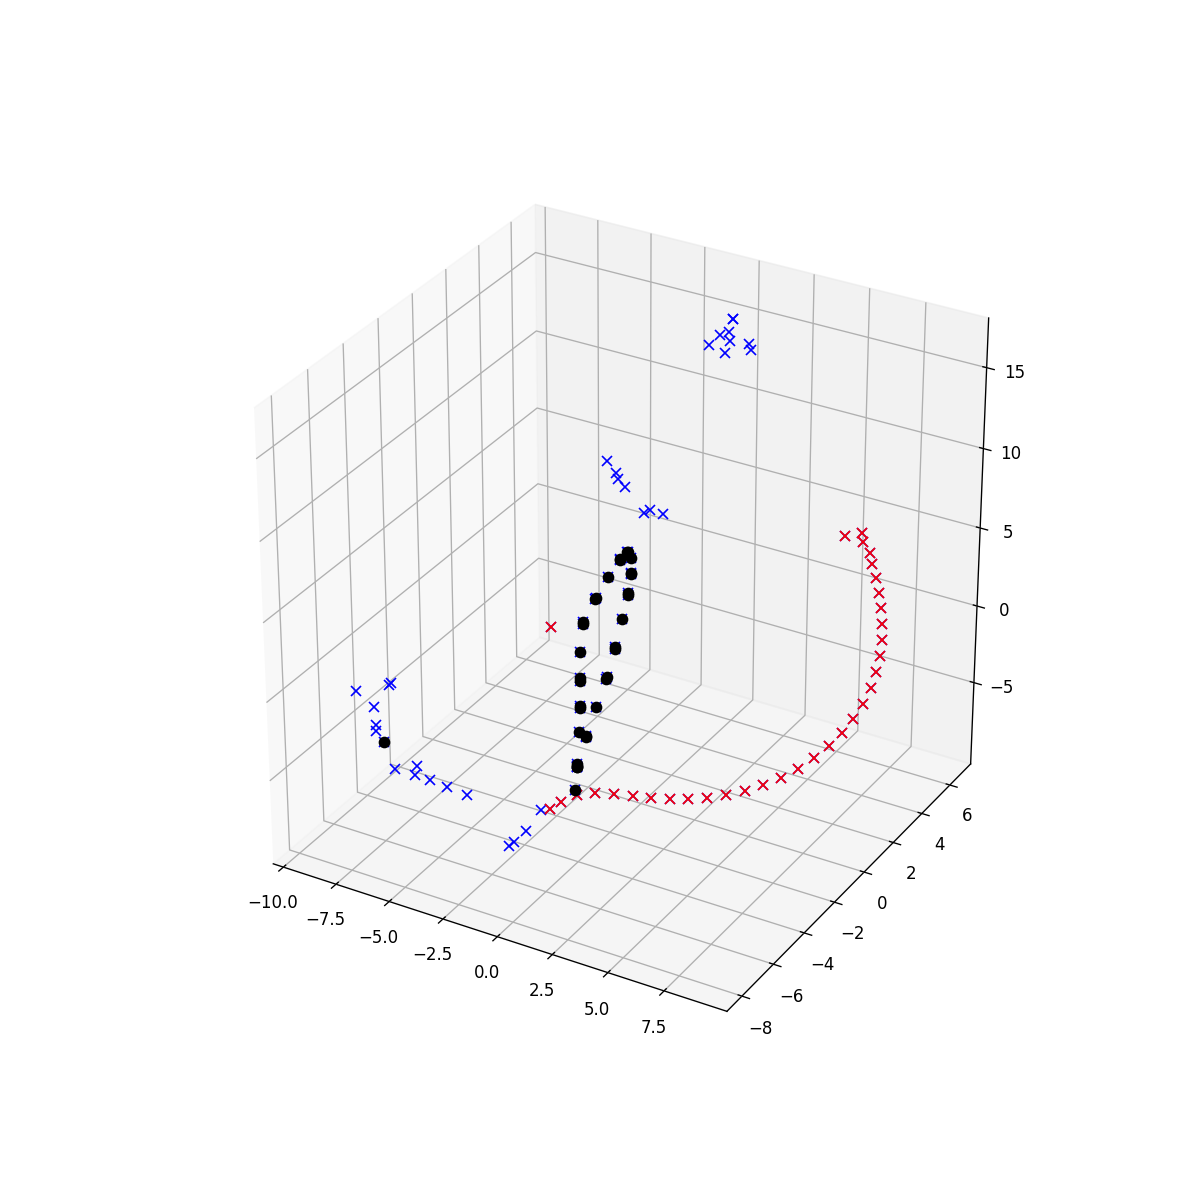

In [40]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(embeddedBottleneckActivations[:,0], embeddedBottleneckActivations[:,1], embeddedBottleneckActivations[:,2], 'bx')
ax.plot(embeddedBottleneckActivations[anomalousInds_1,0], embeddedBottleneckActivations[anomalousInds_1,1], embeddedBottleneckActivations[anomalousInds_1,2], 'rx')
ax.plot(embeddedBottleneckActivations[anomalousInds_2,0], embeddedBottleneckActivations[anomalousInds_2,1], embeddedBottleneckActivations[anomalousInds_2,2], 'ko')
